# C. Make Models

**In order for us to make our predictions, we first take a look at all the different models we've made for the project.**

1. LinearRegression
2. K-Means
3. DecisionTrees
4. Neural Networks

In [608]:
# Splitting data for different models
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/player_data_final.csv')
NBA_col = ['NBA_points', 'NBA_total_rebounds', 'NBA_assists', 'NBA_steals', 'NBA_blocks']
train, test = data.drop(columns=NBA_col), data[NBA_col].set_index(pd.Index(data=data['name'], name='name'))
train.set_index('name', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)

In [609]:
# Re-shuffle data
def shuffle(train, test):
    """
    Shuffe the data around for re-trying results.
    """
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [610]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [611]:
# Total loss function
def all_RMSE(y, y_pred):
    """
    Calculates the RMSE by each of the different stats, and the total RMSE
    """
    rmses = {}
    for num, name in enumerate(y_pred.columns):
        rmses[name] = RMSE(y[:, num], y_pred[name])
    rmses['Total RMSE'] = sum(rmses.values())
    return pd.Series(rmses)

In [909]:
# Standardize our data
def standardize(train, test):
    """
    Standardize both train and test based off of train's means and std's.
    """
    means, stds = train.mean(), train.std()
    norm_train = (train - means) / stds
    norm_test = (test - means) / stds
    return norm_train, norm_test, means, stds

### 1A. Linear Regression (without standardization)

In [840]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [841]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [842]:
# Make predictions
y_pred = linear_model.predict(X_test)

In [843]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

278.08237749515877

In [844]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            278.082377
NBA_total_rebounds     96.608533
NBA_assists            55.887032
NBA_steals             20.956700
NBA_blocks             13.243600
Total RMSE            464.778243
dtype: float64

### 1B. Linear Regression (with standardization)

In [845]:
X_train, X_test, y_train, y_test = shuffle(train, test)

In [847]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [848]:
# Create model
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(norm_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [849]:
# Make predictions
y_pred = linear_model.predict(norm_X_test)

In [850]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

234.42019688280206

In [851]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            234.420197
NBA_total_rebounds    114.331841
NBA_assists            57.531438
NBA_steals             22.170825
NBA_blocks             17.523315
Total RMSE            445.977616
dtype: float64

### 2. K-Means

In [852]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [854]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [855]:
# Fit model and produce labels
from sklearn.cluster import KMeans
k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
X_copy = norm_X_train.copy(deep=True)
X_copy['label'] = k_means_cluster.labels_

In [856]:
# Find the predicted labels of the test set
label_pred = k_means_cluster.predict(norm_X_test)

In [857]:
def find_predictions(labels, X_copy, y_train):
    """
    Finds the predictions for these different players
    """
    all_preds = []
    for label in label_pred:
        similar_players = X_copy[X_copy['label'] == label].index
        similar_avg_stats = y_train.loc[similar_players].mean()
        all_preds.append(similar_avg_stats.values)
    return np.array(all_preds)

In [858]:
# Find stat predictions for the test set
y_pred = find_predictions(label_pred, X_copy, y_train)

In [859]:
# RMSE for points
RMSE(y_test.values[:, 0], y_pred[:, 0])

277.24723946805864

In [860]:
# Total RMSE
all_RMSE(y_pred, y_test)

NBA_points            277.247239
NBA_total_rebounds    129.698871
NBA_assists            97.435012
NBA_steals             24.304547
NBA_blocks             17.091709
Total RMSE            545.777379
dtype: float64

### 2B. Run K-Means multiple times for long-term RMSEs

In [863]:
def run_x_times(x):
    """
    Runs K-Means 'x' number of times to average the RMSEs.
    """
    total_avg = []
    for _ in range(10):
        # Shuffle the data up
        X_train, X_test, y_train, y_test = shuffle(train, test)

        # Standardize data
        norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

        # Fit model and produce labels
        from sklearn.cluster import KMeans
        k_means_cluster = KMeans(n_clusters=120, max_iter=10000, n_init=100).fit(norm_X_train.values)
        X_copy = norm_X_train.copy(deep=True)
        X_copy['label'] = k_means_cluster.labels_

        # Find the predicted labels of the test set
        label_pred = k_means_cluster.predict(norm_X_test)

        def find_predictions(labels, X_copy, y_train):
            """
            Finds the predictions for these different players
            """
            all_preds = []
            for label in label_pred:
                similar_players = X_copy[X_copy['label'] == label].index
                similar_avg_stats = y_train.loc[similar_players].mean()
                all_preds.append(similar_avg_stats.values)
            return np.array(all_preds)

        # Find stat predictions for the test set
        y_pred = find_predictions(label_pred, X_copy, y_train)
        total_avg.append(all_RMSE(y_pred, y_test).values)
        
    return np.array(total_avg)

In [864]:
avgs = run_x_times(10)

In [865]:
for i in range(5):
    print(np.mean(avgs[:, i]))

311.07452638669963
138.0932831781309
85.49283703995015
26.49215157210408
19.579838368877425


### 3. Decision Trees

In [ ]:
# Shuffle data
X_train, X_test, y_train, y_test = shuffle(train, test)

In [866]:
# Standardize data
norm_X_train, norm_X_test, _, _ = standardize(X_train, X_test)

In [867]:
# Create model
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(min_samples_split=5, max_depth=15)
DTR.fit(norm_X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [868]:
# Training RMSE
all_RMSE(DTR.predict(norm_X_train), y_train)

NBA_points            121.933354
NBA_total_rebounds     61.655122
NBA_assists            33.242502
NBA_steals             11.319064
NBA_blocks             12.268759
Total RMSE            240.418800
dtype: float64

In [869]:
# Test total RMSE
all_RMSE(DTR.predict(norm_X_test), y_test)

NBA_points            375.869899
NBA_total_rebounds    146.841167
NBA_assists           113.851023
NBA_steals             32.598454
NBA_blocks             18.929659
Total RMSE            688.090201
dtype: float64

### 3.1 Trying variety of different Decision Trees

In [870]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

In [871]:
DT_errors = []
ET_errors = []
RF_errors = []

def fit_predict_error(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return RMSE(model.predict(X_test), y_test)

for i in range(1, 25):
    DTR = DecisionTreeRegressor(max_depth=i)
    error = fit_predict_error(DTR, norm_X_train, y_train, norm_X_test, y_test)
    DT_errors.append(error.values)
    
    ETR = ExtraTreesRegressor(max_depth=i)
    error = fit_predict_error(ETR, norm_X_train, y_train, norm_X_test, y_test)
    ET_errors.append(error.values)
    
    RFR = RandomForestRegressor(max_depth=i)
    error = fit_predict_error(RFR, norm_X_train, y_train, norm_X_test, y_test)
    RF_errors.append(error.values)

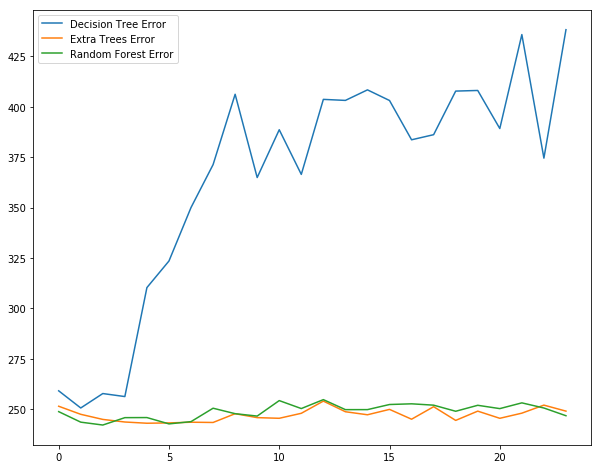

In [1078]:
import matplotlib.pyplot as plt

# Plotting RMSE's for points
plt.figure(figsize=(10, 8))
plt.plot(np.array(DT_errors)[:, 0], label='Decision Tree Error')
plt.plot(np.array(ET_errors)[:, 0], label='Extra Trees Error')
plt.plot(np.array(RF_errors)[:, 0], label='Random Forest Error')
plt.legend()
plt.show();

### 4. Neural Networks

In [1079]:
# Shuffle the data up
X_train, X_test, y_train, y_test = shuffle(train, test)

In [1080]:
# Standardize data
norm_X_train, norm_X_test, x_means, x_stds = standardize(X_train, X_test)

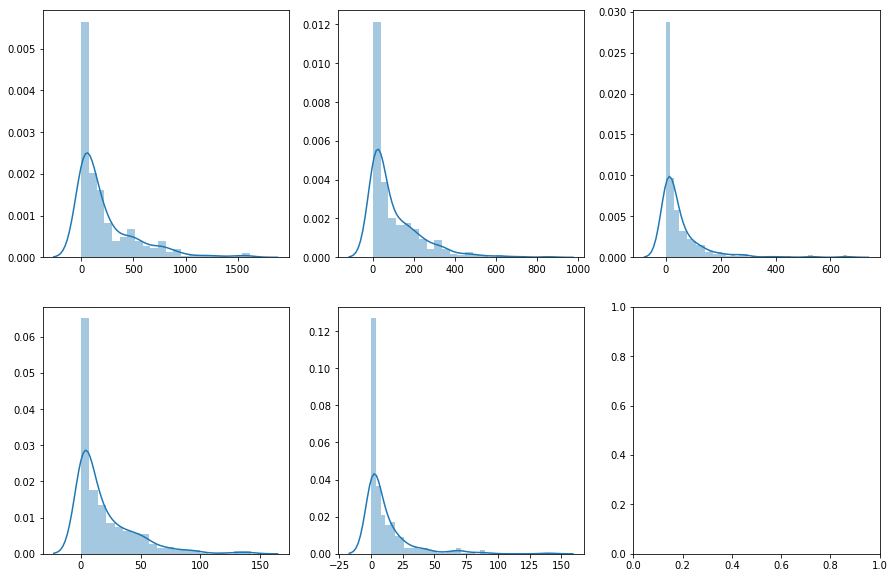

In [1081]:
# Y-value skewness
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col_num in range(len(y_train.columns)):
    sns.distplot(y_train.iloc[:, col_num].to_frame(), ax=axes[col_num // 3][col_num % 3]);

In [1082]:
### STANDARDIZE Y-VALUES (this is because y_values are so skewed)
norm_y_train, _, y_means, y_stds = standardize(y_train, y_test)

In [1083]:
# Import libraries for model
import keras
from keras.models import Sequential
from keras.layers import Dense

In [1084]:
def make_nn_arch():
    """
    Make basic neural network architecture for our dataset.
    """
    model = Sequential()
    model.add(Dense(35, activation='tanh', input_shape=(28,)))
    model.add(Dense(15, activation='tanh', input_shape=(35,)))
    model.add(Dense(1, activation='tanh', input_shape=(15,)))
    # For a mean squared error regression problem
    model.compile(
        optimizer=keras.optimizers.SGD(
            lr=0.001,
            momentum=0.9,
            nesterov=True
        ), #How to Learn
        loss='mse', # What to Learn
    )
    return model

In [1085]:
# Create and fit Neural Network
model = make_nn_arch()
model.fit(
    x=norm_X_train,
    y=norm_y_train['NBA_points'], 
    epochs=100,
)

Epoch 1/100
420/420 [==============================] - 0s 173us/step - loss: 1.0978
Epoch 2/100
420/420 [==============================] - 0s 33us/step - loss: 0.9852
Epoch 3/100
420/420 [==============================] - 0s 37us/step - loss: 0.9595
Epoch 4/100
420/420 [==============================] - 0s 35us/step - loss: 0.9421
Epoch 5/100
420/420 [==============================] - 0s 53us/step - loss: 0.9284
Epoch 6/100
420/420 [==============================] - 0s 41us/step - loss: 0.9132
Epoch 7/100
420/420 [==============================] - 0s 44us/step - loss: 0.9075
Epoch 8/100
420/420 [==============================] - 0s 39us/step - loss: 0.8957
Epoch 9/100
420/420 [==============================] - 0s 40us/step - loss: 0.8926
Epoch 10/100
420/420 [==============================] - 0s 39us/step - loss: 0.8792
Epoch 11/100
420/420 [==============================] - 0s 40us/step - loss: 0.8866
Epoch 12/100
420/420 [==============================] - 0s 41us/step - loss: 0.8774


In [1166]:
# Loss function
def RMSE(y, y_pred):
    """
    Calculates the root mean squared error of the model's predictions.
    """
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [1167]:
# Make predictions
y_pred = model.predict(norm_X_test)

In [1168]:
# RMSE for points
RMSE(((y_pred * y_stds['NBA_points']) + y_means['NBA_points']).flatten(), y_test['NBA_points'])

326.9834095045833

### 4.1 Make Neural Networks for all stats

In [1089]:
def train_all_and_predict():
    
    rmses = []
    
    for column in y_train.columns:

        # Create and fit Neural Network
        model = make_nn_arch()
        model.fit(
            x=norm_X_train,
            y=norm_y_train[column], 
            epochs=100,
        )
        y_pred = model.predict(norm_X_test)

        # RMSE by stat category
        rmse = RMSE(((y_pred * y_stds[column]) + y_means[column]).flatten(), y_test[column])
        rmses.append(rmse)
    
    return rmses

In [1090]:
rmses = train_all_and_predict()

Epoch 1/100
420/420 [==============================] - 0s 163us/step - loss: 1.0281
Epoch 2/100
420/420 [==============================] - 0s 40us/step - loss: 0.9823
Epoch 3/100
420/420 [==============================] - 0s 34us/step - loss: 0.9493
Epoch 4/100
420/420 [==============================] - 0s 42us/step - loss: 0.9316
Epoch 5/100
420/420 [==============================] - 0s 34us/step - loss: 0.9141
Epoch 6/100
420/420 [==============================] - 0s 39us/step - loss: 0.9008
Epoch 7/100
420/420 [==============================] - 0s 40us/step - loss: 0.8983
Epoch 8/100
420/420 [==============================] - 0s 44us/step - loss: 0.8793
Epoch 9/100
420/420 [==============================] - 0s 37us/step - loss: 0.8691
Epoch 10/100
420/420 [==============================] - 0s 35us/step - loss: 0.8604
Epoch 11/100
420/420 [==============================] - 0s 36us/step - loss: 0.8555
Epoch 12/100
420/420 [==============================] - 0s 44us/step - loss: 0.8482


420/420 [==============================] - 0s 35us/step - loss: 0.6179
Epoch 96/100
420/420 [==============================] - 0s 37us/step - loss: 0.6135
Epoch 97/100
420/420 [==============================] - 0s 42us/step - loss: 0.6093
Epoch 98/100
420/420 [==============================] - 0s 34us/step - loss: 0.6092
Epoch 99/100
420/420 [==============================] - 0s 36us/step - loss: 0.6082
Epoch 100/100
420/420 [==============================] - 0s 36us/step - loss: 0.6057
Epoch 1/100
420/420 [==============================] - 0s 170us/step - loss: 1.2104
Epoch 2/100
420/420 [==============================] - 0s 34us/step - loss: 1.0278
Epoch 3/100
420/420 [==============================] - 0s 39us/step - loss: 0.9700
Epoch 4/100
420/420 [==============================] - 0s 33us/step - loss: 0.9289
Epoch 5/100
420/420 [==============================] - 0s 33us/step - loss: 0.8941
Epoch 6/100
420/420 [==============================] - 0s 34us/step - loss: 0.8716
Epoch 7/1

420/420 [==============================] - 0s 35us/step - loss: 0.6518
Epoch 90/100
420/420 [==============================] - 0s 36us/step - loss: 0.6503
Epoch 91/100
420/420 [==============================] - 0s 35us/step - loss: 0.6502
Epoch 92/100
420/420 [==============================] - 0s 35us/step - loss: 0.6493
Epoch 93/100
420/420 [==============================] - 0s 35us/step - loss: 0.6428
Epoch 94/100
420/420 [==============================] - 0s 36us/step - loss: 0.6434
Epoch 95/100
420/420 [==============================] - 0s 32us/step - loss: 0.6408
Epoch 96/100
420/420 [==============================] - 0s 33us/step - loss: 0.6373
Epoch 97/100
420/420 [==============================] - 0s 33us/step - loss: 0.6383
Epoch 98/100
420/420 [==============================] - 0s 36us/step - loss: 0.6362
Epoch 99/100
420/420 [==============================] - 0s 34us/step - loss: 0.6365
Epoch 100/100
420/420 [==============================] - 0s 35us/step - loss: 0.6336
Epoc

In [1091]:
rmses

[271.16632210053496,
 117.19011412157963,
 70.98827829693937,
 23.254384958317246,
 16.18415020277134]